## Importación de las librerías

In [49]:
from scipy import stats
from sklearn import preprocessing

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## Importación del dataset

In [50]:
data_df = pd.read_csv('/kaggle/input/cajamar-malbec/UH_2023/UH_2023_TRAIN.txt', sep='|')
data_df.head()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.0,22215.0
1,14,84318,515,4,660,26,2,0,1,0.0,22215.0
2,14,85579,340,4,520,32,2,0,1,0.0,20978.0
3,14,69671,340,4,520,32,2,0,1,0.0,40722.0
4,14,14001,852,14,NaN,81,1,0,1,0.0,14126.0


Número de filas y columnas

In [5]:
data_df.shape

(9601, 11)

Un id_finca que pertenece a un id_zona, puede tener superficies diferentes ya que puede ser que a una variedad o modo de la uva se le otorge mayor superficie que a otras de la finca 

In [51]:
data_df.tail()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
9596,22,37461,239,6,700,52,2,0,1,3.6800,NaN
9597,22,58769,239,6,700,32,2,0,1,4.2500,NaN
9598,22,58769,239,6,700,59,2,0,1,4.0700,NaN
9599,22,88928,239,6,700,40,2,0,1,4.5727,NaN
9600,22,88928,239,6,700,52,2,0,1,1.6099,NaN


## Análisis exploratorio de los datos

### Descripción inicial

- Variable altitud presenta algunos nulos y está como string ya que contiene cosas como '450-460' (pensar que hacer para estos casos)
- Producción tiene nulos pero son las muestras a predecir

In [52]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601 entries, 0 to 9600
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CAMPAÑA      9601 non-null   int64  
 1   ID_FINCA     9601 non-null   int64  
 2   ID_ZONA      9601 non-null   int64  
 3   ID_ESTACION  9601 non-null   int64  
 4   ALTITUD      9547 non-null   object 
 5   VARIEDAD     9601 non-null   int64  
 6   MODO         9601 non-null   int64  
 7   TIPO         9601 non-null   int64  
 8   COLOR        9601 non-null   int64  
 9   SUPERFICIE   9601 non-null   float64
 10  PRODUCCION   8526 non-null   float64
dtypes: float64(2), int64(8), object(1)
memory usage: 825.2+ KB


In [54]:
data_df['ALTITUD'].value_counts()

455-470    703
650-660    680
455-465    431
630-640    430
600-670    419
          ... 
385          4
440          3
800          2
525          2
390          1
Name: ALTITUD, Length: 84, dtype: int64

Convertimos la variable ALTITUD por la media

In [66]:
def transform_altitud(alt):
    if type(alt) is str:
        alt_list = alt.split("-")
        alt_list = list(map(float, alt_list))
        return np.mean(alt_list) 
    return alt

In [68]:
data_df['altitud_transform'] = data_df['ALTITUD'].apply(lambda alt: transform_altitud(alt))

In [69]:
data_df.head()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,altitud_transform
0,14,76953,515,4,660,26,2,0,1,0.0,22215.0,660.0
1,14,84318,515,4,660,26,2,0,1,0.0,22215.0,660.0
2,14,85579,340,4,520,32,2,0,1,0.0,20978.0,520.0
3,14,69671,340,4,520,32,2,0,1,0.0,40722.0,520.0
4,14,14001,852,14,NaN,81,1,0,1,0.0,14126.0,NaN


### Variables continuas solas

In [71]:
continous_vars = ['SUPERFICIE', 'PRODUCCION', 'altitud_transform']
categorical_vars = ['CAMPAÑA', 'ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR']

Se debe tener en cuenta que no se dispone del dato de la superficie para antes del 2020

- Hay superficies y producción muy grandes y pequeñas.

In [72]:
data_df[data_df['SUPERFICIE']>0][continous_vars].describe()

,SUPERFICIE,PRODUCCION,altitud_transform
count,3083.000000,2017.000000,3066.000000
mean,2.172191,9823.435249,580.579746
std,2.595080,13563.035658,74.559639
min,0.000720,0.718000,370.000000
25%,0.630000,2060.000000,515.000000
50%,1.341600,4850.010000,610.000000
75%,2.709000,11872.000000,635.000000
max,26.850000,130950.000000,750.000000


Número de superficies a 0, es decir, datos de campañas antes del 2020

Existen 6476 muestras del de que no disponemos datos de superficie

In [73]:
data_df[(data_df['CAMPAÑA'] < 20)]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,altitud_transform
0,14,76953,515,4,660,26,2,0,1,0.0,22215.0,660.0
1,14,84318,515,4,660,26,2,0,1,0.0,22215.0,660.0
2,14,85579,340,4,520,32,2,0,1,0.0,20978.0,520.0
3,14,69671,340,4,520,32,2,0,1,0.0,40722.0,520.0
4,14,14001,852,14,NaN,81,1,0,1,0.0,14126.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6471,19,37461,239,6,700,52,2,0,1,0.0,22947.5,700.0
6472,19,58769,239,6,700,32,2,0,1,0.0,30840.0,700.0
6473,19,58769,239,6,700,59,2,0,1,0.0,24090.0,700.0
6474,19,88928,239,6,700,40,2,0,1,0.0,35920.0,700.0


Para las campañas de las que disponemos superficie, también existen superficies a 0

In [77]:
data_df[(data_df['CAMPAÑA'] >= 20) & (data_df['SUPERFICIE'] == 0)].shape

(42, 12)

**Outliers en las variables continuas**

<AxesSubplot:xlabel='altitud_transform'>

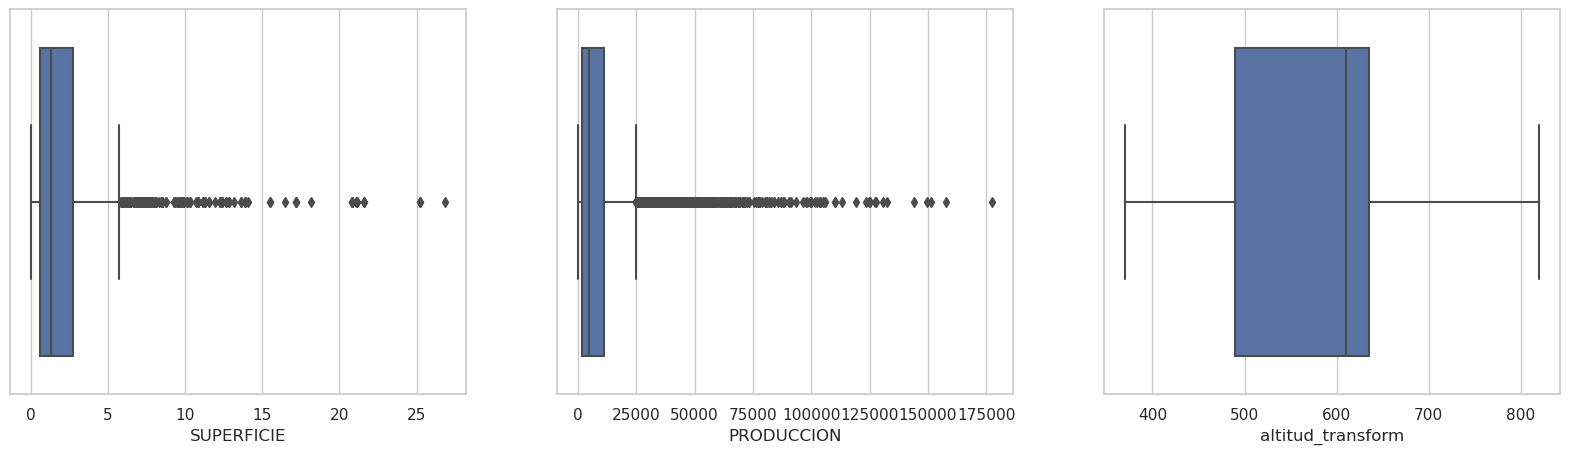

In [82]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.boxplot(x=data_df[data_df['SUPERFICIE']>0]['SUPERFICIE'], ax=axes[0])
sns.boxplot(x=data_df['PRODUCCION'], ax=axes[1])
sns.boxplot(x=data_df['altitud_transform'], ax=axes[2])

### Variables continuas cruzadas con otras continuas

Está claro que si la superficie crece la producción también

<AxesSubplot:xlabel='altitud_transform', ylabel='PRODUCCION'>

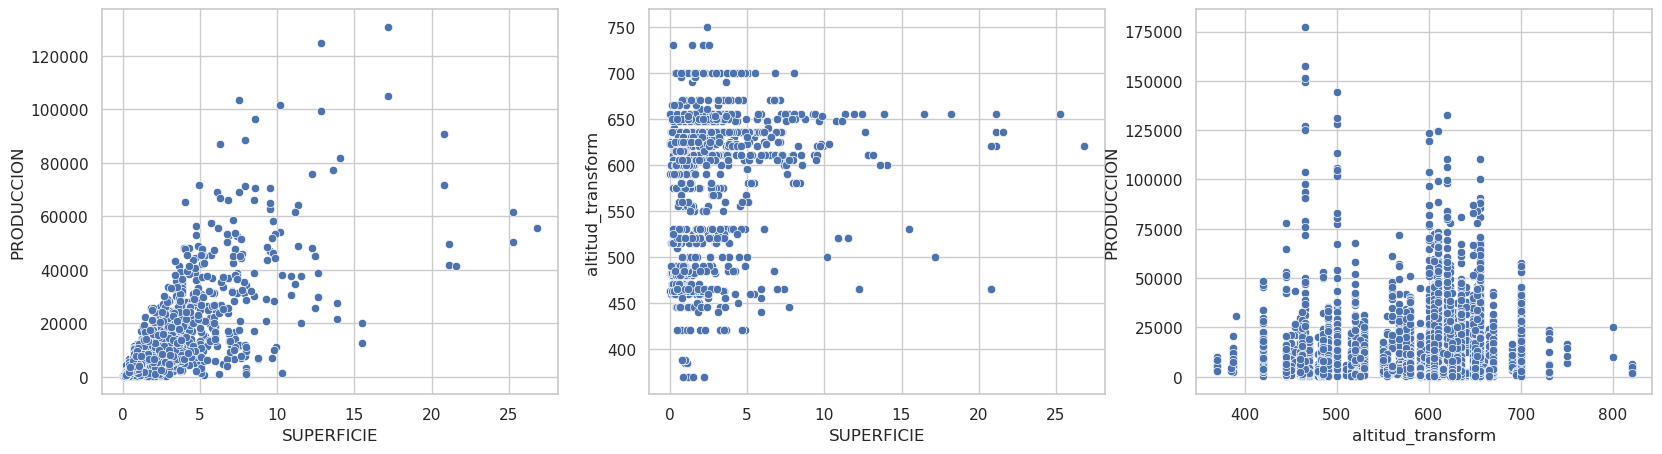

In [84]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.scatterplot(data=data_df[data_df['SUPERFICIE']>0], x="SUPERFICIE", y="PRODUCCION", ax=axes[0])
sns.scatterplot(data=data_df[data_df['SUPERFICIE']>0], x="SUPERFICIE", y="altitud_transform", ax=axes[1])
sns.scatterplot(data=data_df, x="altitud_transform", y="PRODUCCION", ax=axes[2])

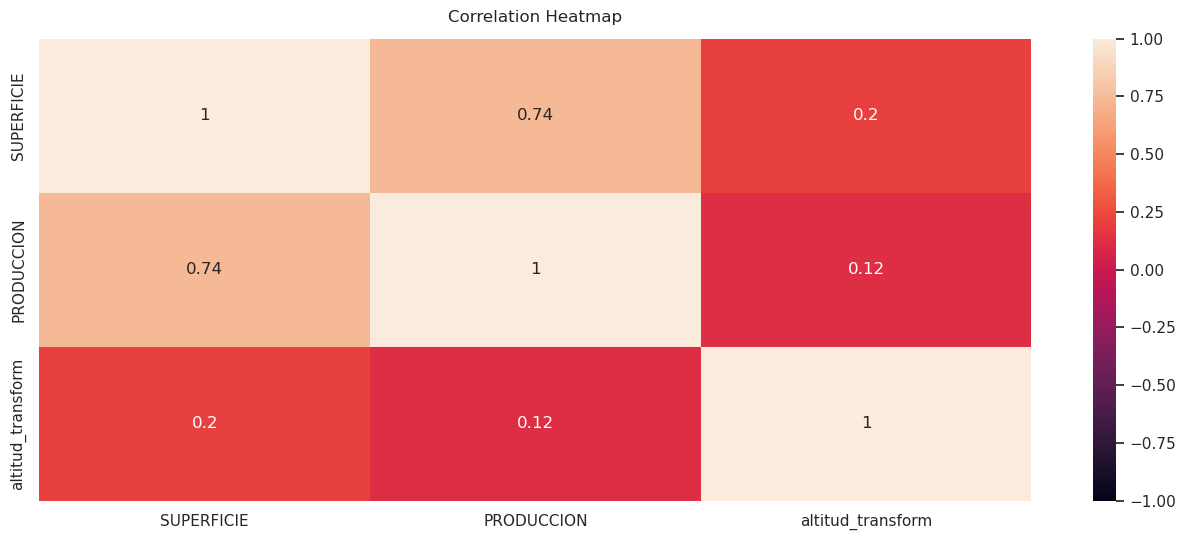

In [85]:
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(data_df[data_df['SUPERFICIE']>0][continous_vars].corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Variables categoricas

In [91]:
for var in categorical_vars:
    print("VARIABLE", var)
    print(data_df[var].value_counts())
    print("-"*100)

VARIABLE CAMPAÑA
14    1148
15    1116
16    1079
22    1075
18    1061
19    1055
21    1044
17    1017
20    1006
Name: CAMPAÑA, dtype: int64
----------------------------------------------------------------------------------------------------
VARIABLE ID_FINCA
4024     59
49636    54
48827    47
84174    46
61177    36
         ..
83633     1
44142     1
81399     1
12889     1
83256     1
Name: ID_FINCA, Length: 1231, dtype: int64
----------------------------------------------------------------------------------------------------
VARIABLE ID_ZONA
441    703
272    419
134    406
464    378
510    283
      ... 
772      2
515      2
672      1
862      1
126      1
Name: ID_ZONA, Length: 125, dtype: int64
----------------------------------------------------------------------------------------------------
VARIABLE ID_ESTACION
12    2060
5     1155
7     1113
16    1087
15     956
19     937
18     773
14     606
10     252
3      249
9      182
8       93
6       46
2       45
13    

- Hay variedades de uva que tienen más observaciones que otras
- Modo parecen tener mismo número de muestras aproximadamente
- Tipo la mayoría son 0
- Color tiene más muestras en 1, aunque también en 0

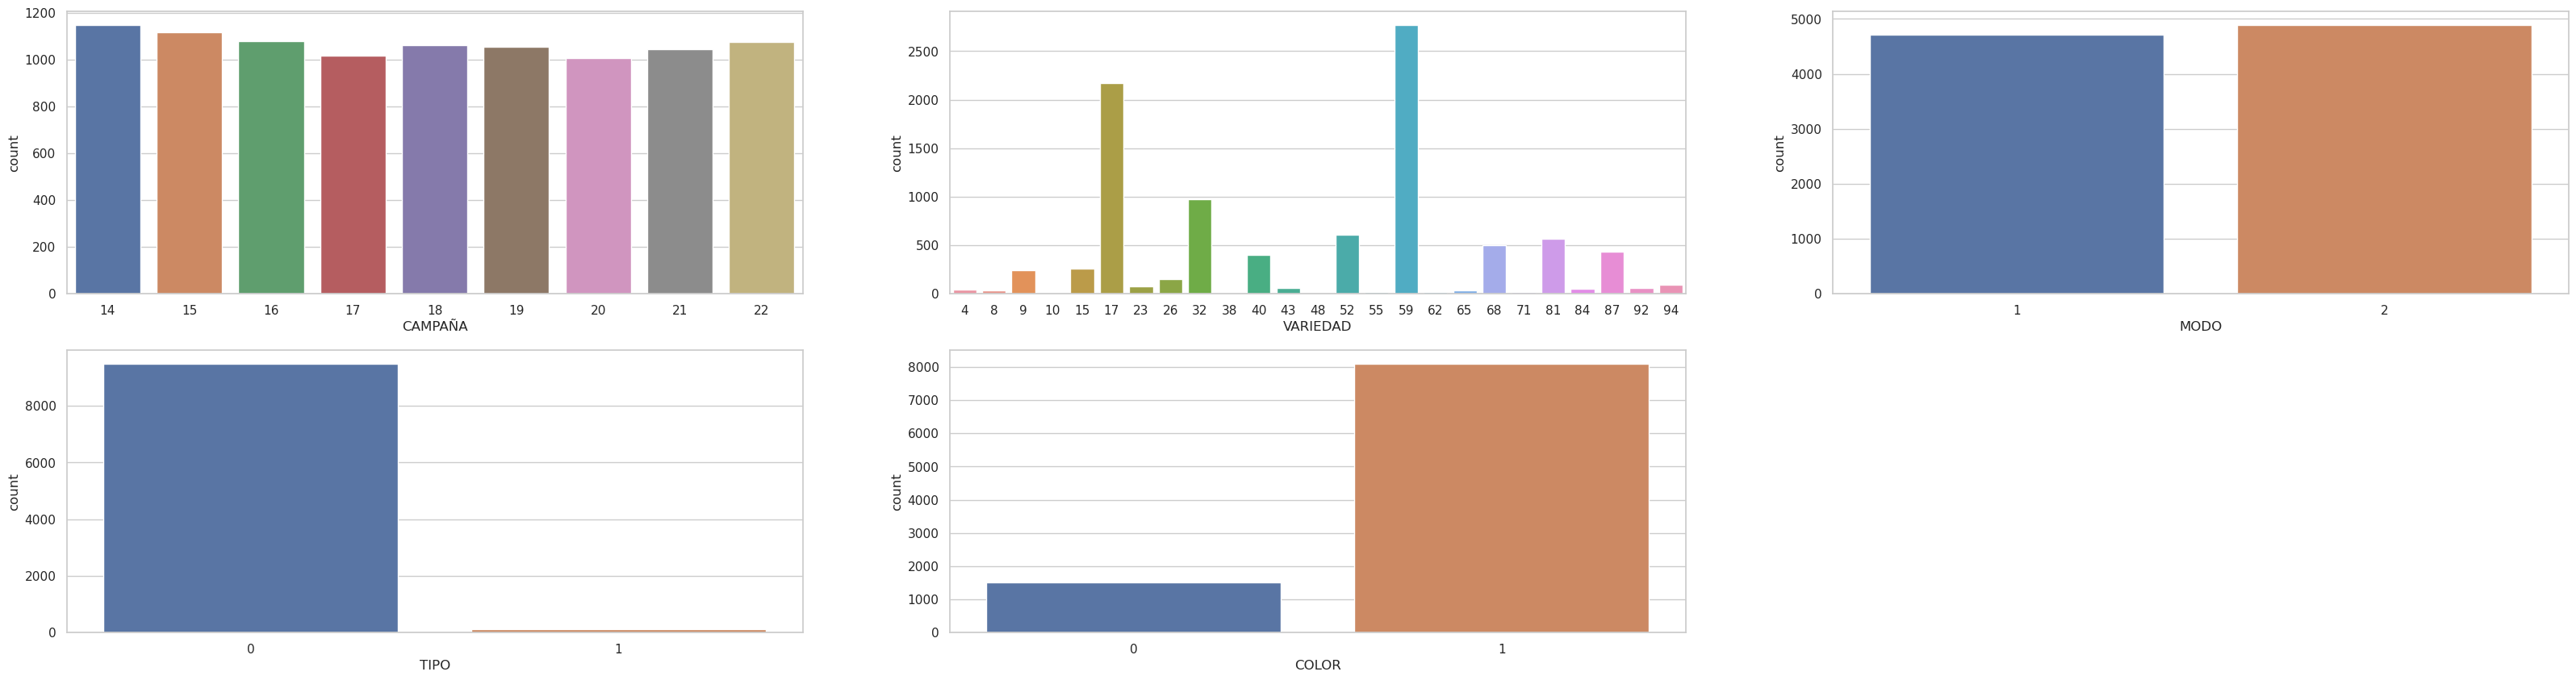

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(40, 10))
fig.delaxes(axes[1,2])

for n, var in enumerate(['CAMPAÑA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR']):
    sns.countplot(data = data_df, x=var, ax=axes[n//3][n%3])

### Variables categóricas cruzadas contra otras categóricas

Calculamos la matriz de V'Cramer entre las variables categóricas

In [93]:
label_encoder = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

for var in categorical_vars:
    data_encoded[var] = label_encoder.fit_transform(data_df[var])

data_encoded.head()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,VARIEDAD,MODO,TIPO,COLOR
0,0,936,68,4,7,1,0,1
1,0,1021,68,4,7,1,0,1
2,0,1042,40,4,8,1,0,1
3,0,838,40,4,8,1,0,1
4,0,175,108,14,20,0,0,1


In [94]:
def cramers_V(var1,var2) :
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = stats.chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

def get_cramers_df(data):
    rows = []
    for var1 in data:
        col = []
        for var2 in data:
            cramers = cramers_V(data[var1], data[var2]) # Cramer's V test
            col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
        rows.append(col)
    cramers_results = np.array(rows)
    return pd.DataFrame(cramers_results, columns = data.columns, index= data.columns)

In [95]:
cramers_df = get_cramers_df(data_encoded)
cramers_df

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,VARIEDAD,MODO,TIPO,COLOR
CAMPAÑA,1.00,0.06,0.01,0.00,0.01,0.04,0.00,0.00
ID_FINCA,0.06,1.00,1.00,1.00,0.61,0.76,0.87,0.75
ID_ZONA,0.01,1.00,1.00,0.92,0.13,0.23,0.25,0.22
ID_ESTACION,0.00,1.00,0.92,1.00,0.03,0.05,0.05,0.05
VARIEDAD,0.01,0.61,0.13,0.03,1.00,0.33,0.40,1.00
MODO,0.04,0.76,0.23,0.05,0.33,1.00,0.00,0.01
TIPO,0.00,0.87,0.25,0.05,0.40,0.00,0.99,0.00
COLOR,0.00,0.75,0.22,0.05,1.00,0.01,0.00,1.00


Cosas interesantes:
- **zona con estación alta relación**
- ¿variedad con color?
- ¿consideramos relaciones de id_finca importantes?

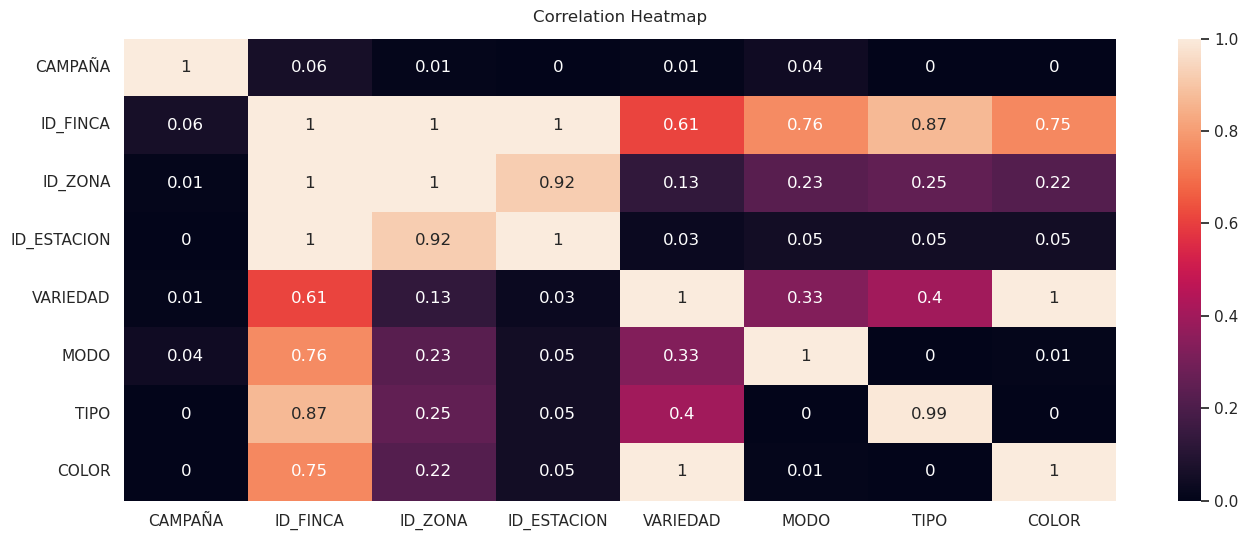

In [96]:
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(cramers_df, vmin=0, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Variables categóricas contra las continuas (también con la objetivo)

- para cada variedad la producción cambia
- para el modo y tipo también existe diferencia en la producción
- para el color no se ve mucha diferencia en la producción

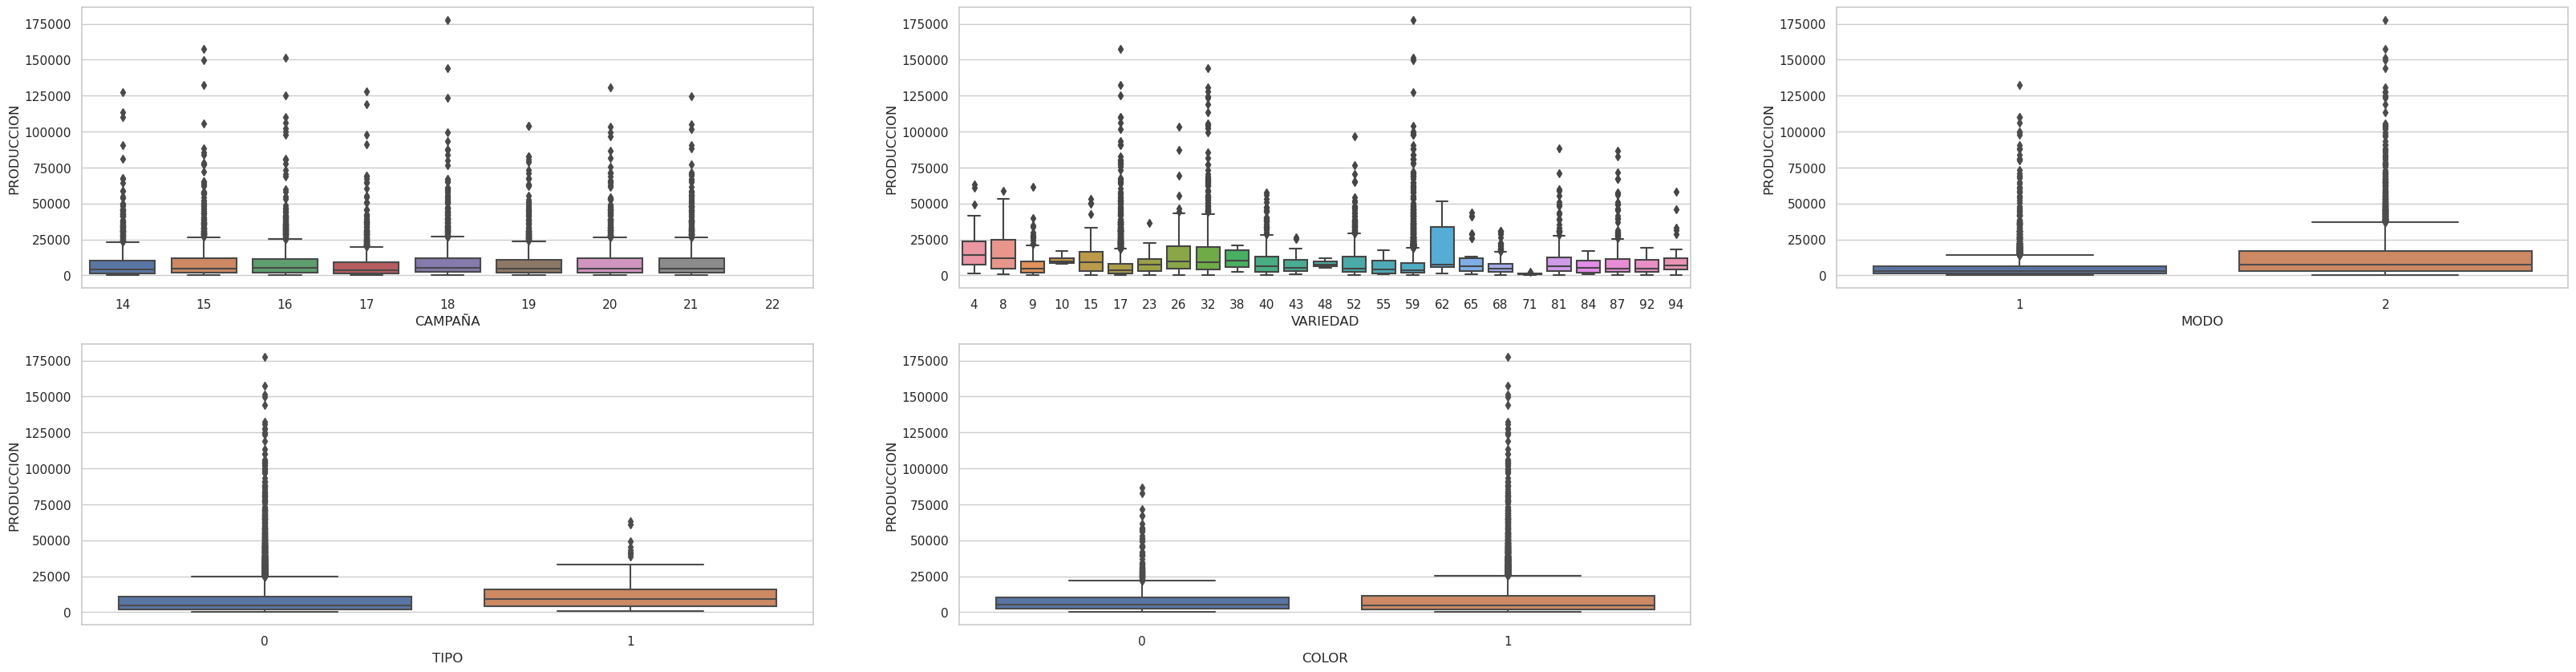

In [107]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(40, 10))
fig.delaxes(axes[1,2])

for n, var in enumerate(['CAMPAÑA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR']):
    sns.boxplot(data = data_df, x=var, y='PRODUCCION', ax=axes[n//3][n%3])

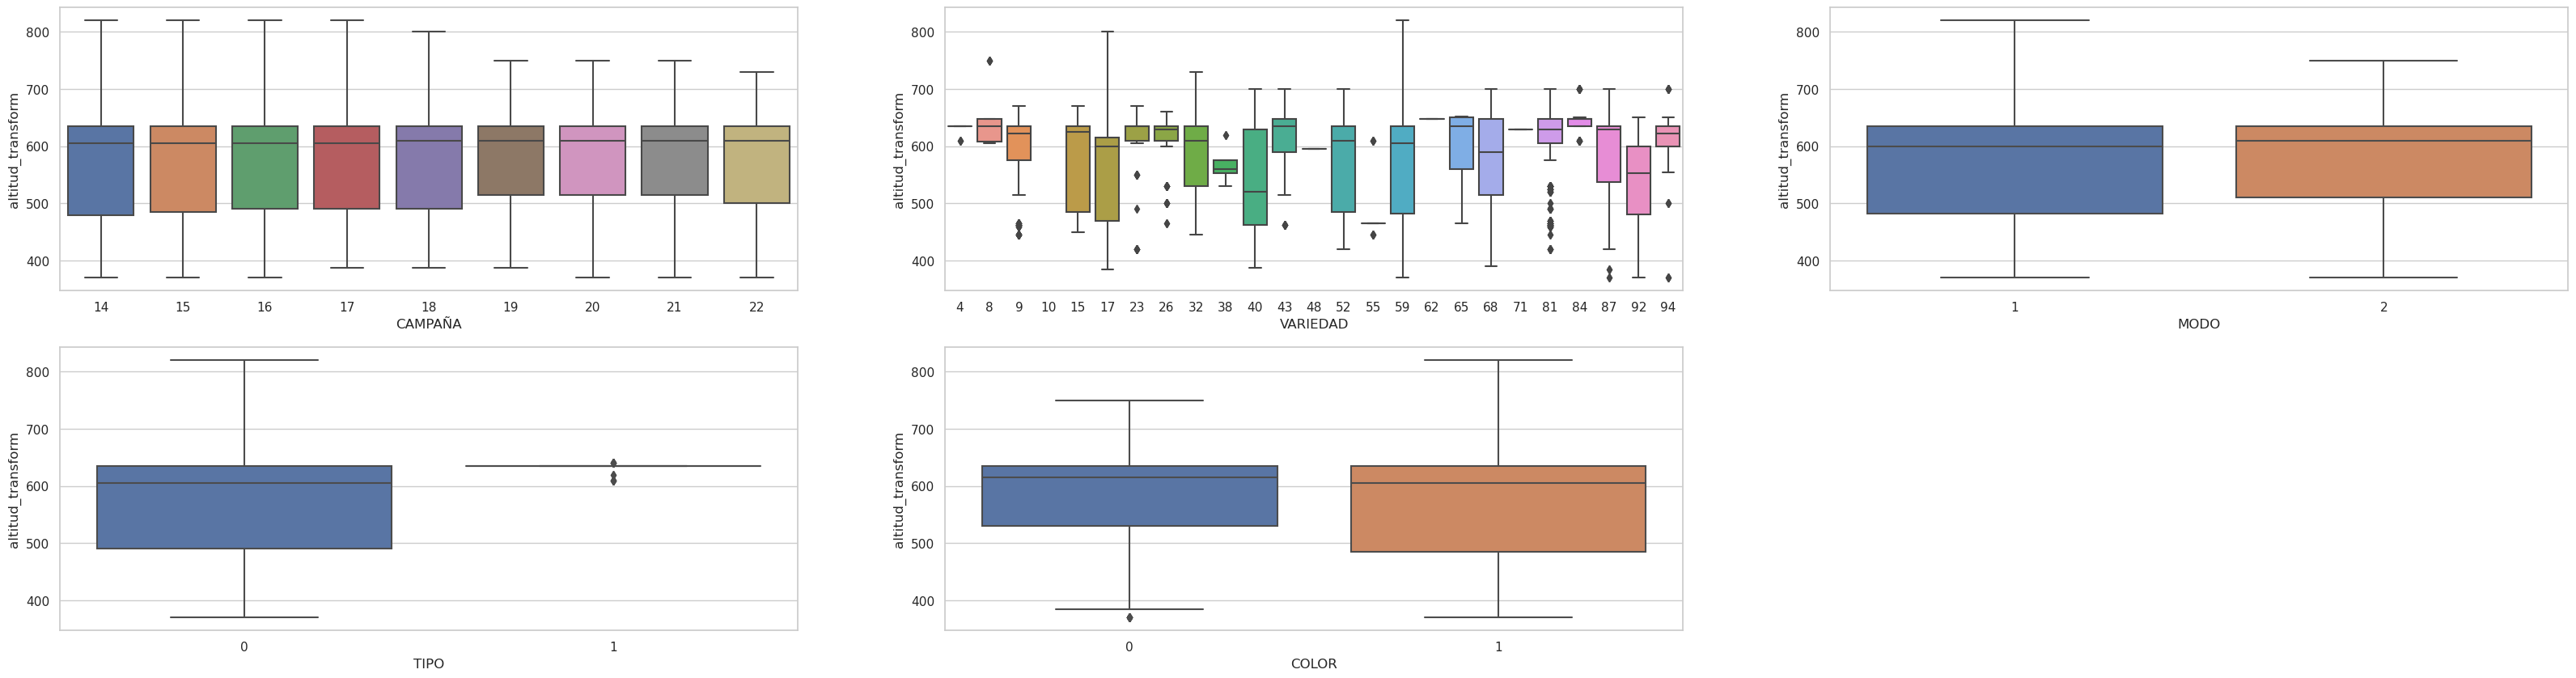

In [108]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(40, 10))
fig.delaxes(axes[1,2])

for n, var in enumerate(['CAMPAÑA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR']):
    sns.boxplot(data = data_df, x=var, y='altitud_transform', ax=axes[n//3][n%3])

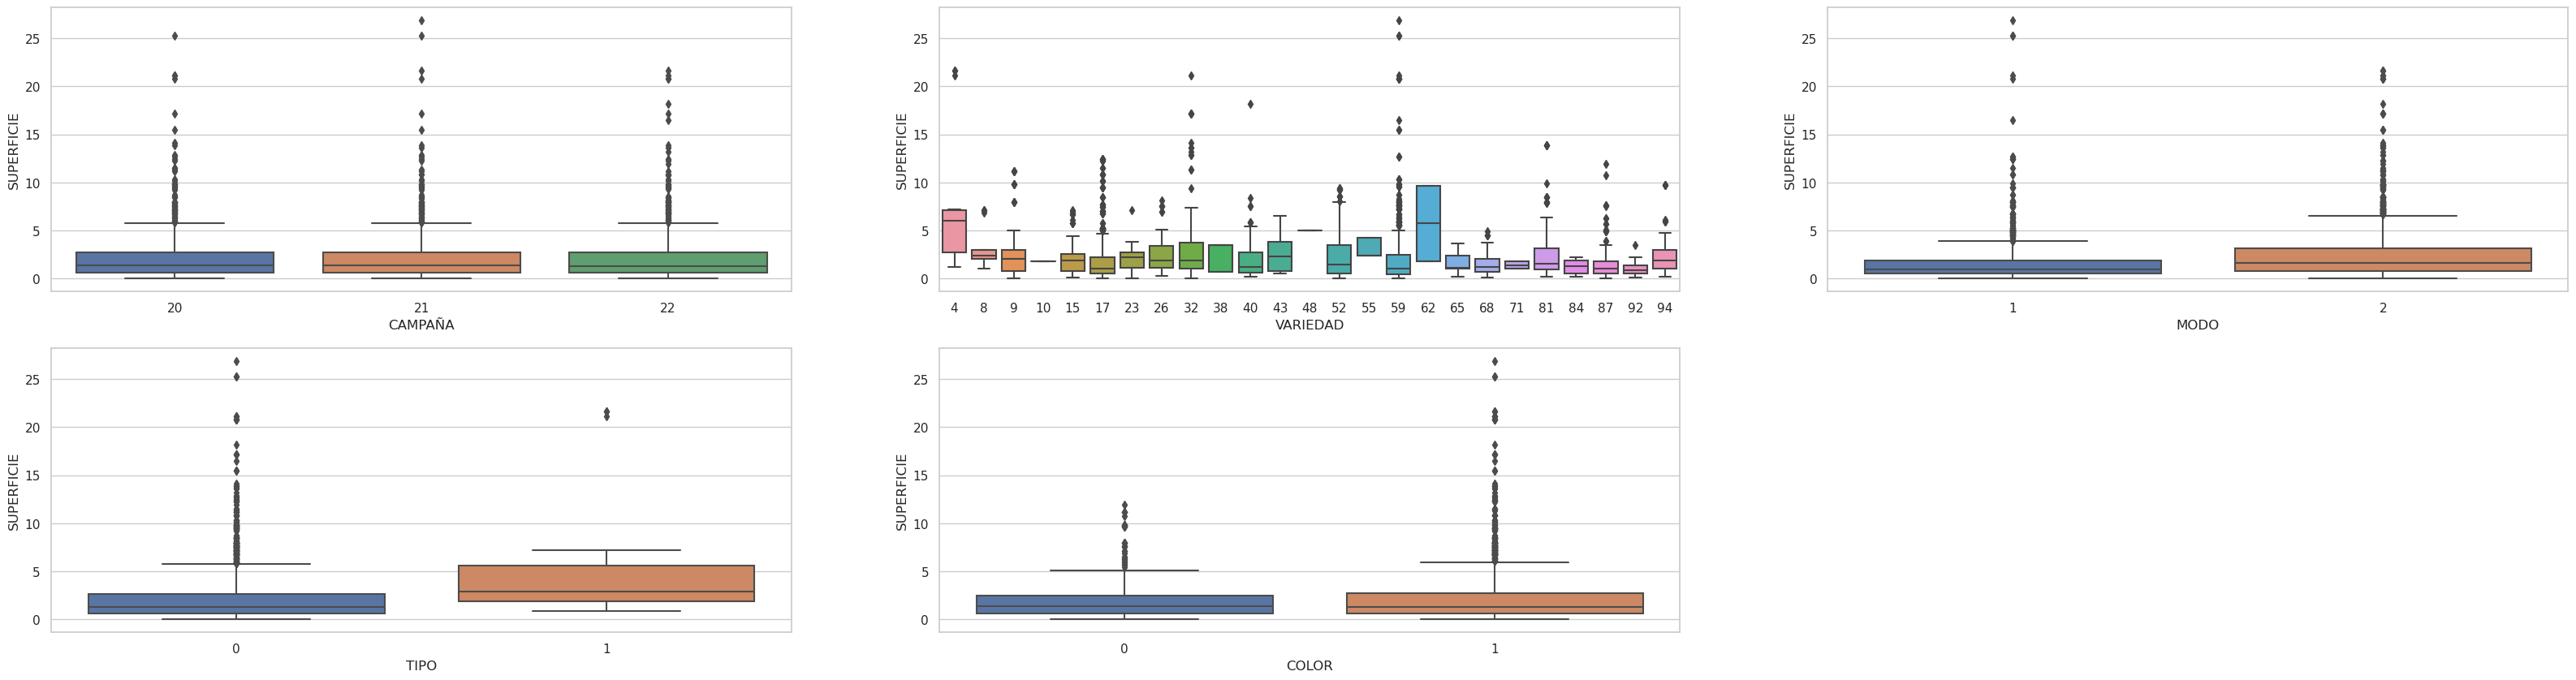

In [110]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(40, 10))
fig.delaxes(axes[1,2])

for n, var in enumerate(['CAMPAÑA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR']):
    sns.boxplot(data = data_df[data_df['SUPERFICIE']>0], x=var, y='SUPERFICIE', ax=axes[n//3][n%3])